##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os

from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)

In [2]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths

In [3]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [4]:
path_shiny_mouse = os.path.join(csv_path, "current_shiny_mouse.csv")
path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")

##### Start Code

In [5]:
fields_shiny = ["cell_name", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng"]
shiny_mouse = read_file(path_shiny_mouse, fields_shiny) #10839 rows
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe


In [6]:
shiny_mouse.dropna(subset=["cell_specimen_project"],inplace=True) #10834 rows
shiny_human.dropna(subset=["cell_specimen_project"],inplace=True) #3578 rows

##### Filter project code

In [7]:
shinym = filter_df(shiny_mouse, "cell_specimen_project", "mIVSCC-MET") #8371 rows
shinyh = filter_df(shiny_human, "cell_specimen_project", "hIVSCC-MET") #1566 rows

INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == mIVSCC-MET
INFO:functions.temp_funcs:Filtered dataframe based on cell_specimen_project == hIVSCC-MET


In [9]:
shinym.rename(columns={"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
                      "rna_amplification_pass_fail" : "RNA amp Pass/Fail",
                      "marker_sum_norm_label": "NMS score",
                      "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
                      "amplified_quantity_ng" : "Amplified content (ng)"}, inplace=True)
shinyh.rename(columns={"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
                      "rna_amplification_pass_fail" : "RNA amp Pass/Fail",
                      "marker_sum_norm_label": "NMS score",
                      "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
                      "amplified_quantity_ng" : "Amplified content (ng)"}, inplace=True)

C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [10]:
shinym = filter_df(shinym, "RNA amp Pass/Fail", "Fail") 
shinyh = filter_df(shinyh, "RNA amp Pass/Fail", "Fail")
shinym = filter_df(shinym, "NMS Pass/Fail", True) 
shinyh = filter_df(shinyh, "NMS Pass/Fail", True)
shinym = shinym[shinym["cDNA quality (%>400 bp)"] <=1] #1577
shinym = shinym[shinym["Amplified content (ng)"] <=50] #1550
shinyh = shinyh[shinyh["cDNA quality (%>400 bp)"] <=1] #1577
shinyh = shinyh[shinyh["Amplified content (ng)"] <=50] #1550

INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on RNA amp Pass/Fail == Fail
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True
INFO:functions.temp_funcs:Filtered dataframe based on NMS Pass/Fail == True


##### Filter RNA Amp pass_fail

In [11]:
shiny = pd.concat([shinym, shinyh], ignore_index=True, sort =False) #8593
shiny = shiny[shiny["cDNA quality (%>400 bp)"] <=1] #1577
shiny = shiny[shiny["Amplified content (ng)"] <=50] #1550

##### Plots

In [12]:
colors=["#41ab5d", "#ef3b2c"]

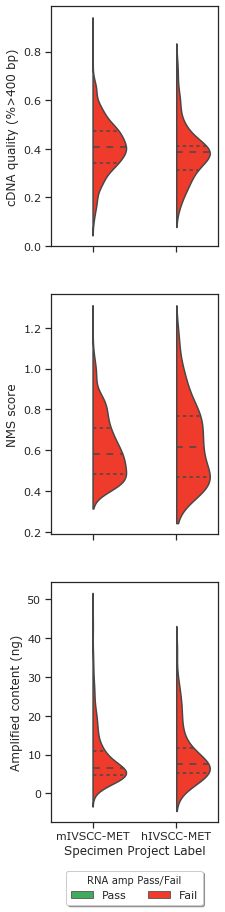

In [13]:
fig_dims = (3, 15)
f, axes = plt.subplots(nrows=3, ncols=1, figsize=fig_dims)

ax = sns.violinplot(x="cell_specimen_project", y="cDNA quality (%>400 bp)", hue="RNA amp Pass/Fail",
                    data=shiny[shiny["cDNA quality (%>400 bp)"] <=1], 
                    order=["mIVSCC-MET", "hIVSCC-MET"], hue_order=["Pass", "Fail"],
                    split=True, inner="quartile", scale="count",
                    palette=colors, saturation=1, ax=axes[0])
ax1 = sns.violinplot(x="cell_specimen_project", y="NMS score", hue="RNA amp Pass/Fail",
                     data=shiny[shiny["NMS score"] <=1.5],
                     order=["mIVSCC-MET", "hIVSCC-MET"], hue_order=["Pass", "Fail"], 
                     split=True, inner="quartile", scale="count",
                     palette=colors, saturation=1, ax=axes[1])
ax2 = sns.violinplot(x="cell_specimen_project", y="Amplified content (ng)", hue="RNA amp Pass/Fail",
                     data=shiny[shiny["Amplified content (ng)"] <=50],
                     order=["mIVSCC-MET", "hIVSCC-MET"], hue_order=["Pass", "Fail"], 
                     split=True, inner="quartile", scale="count",
                     palette=colors, saturation=1, ax=axes[2])

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()

ax.set(xticklabels=[])
ax1.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Specimen Project Label")

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], title="RNA amp Pass/Fail",
               loc='upper center', bbox_to_anchor=(0.5, -0.18),
               fancybox=True, shadow=True, ncol=2)
plt.savefig(plot_path + "rna_amp_violinplot.jpeg", bbox_inches="tight")

In [14]:
shinym.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True) #7369

In [15]:
shinyh.dropna(subset=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], inplace=True) #1208

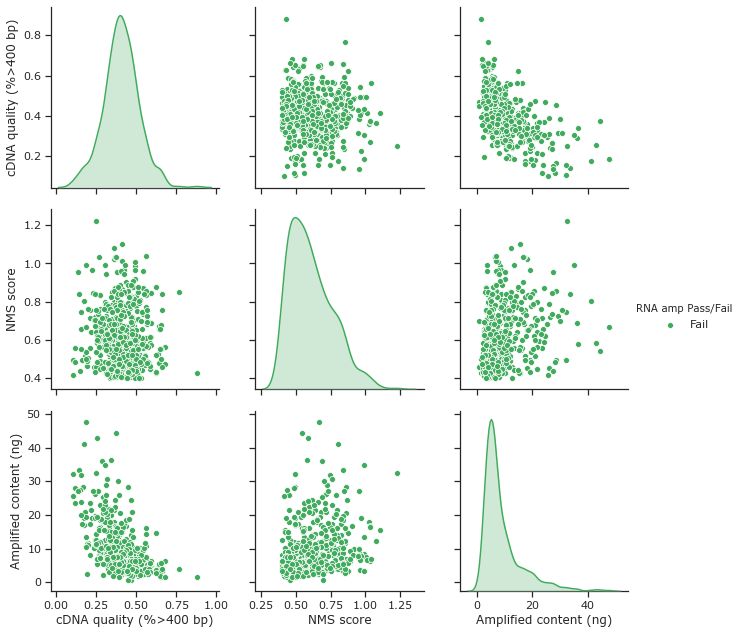

In [18]:
ax = sns.pairplot(data=shinym, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], height=3, 
                  hue = "RNA amp Pass/Fail", hue_order=["Fail"], palette=colors)
plt.savefig(plot_path + "mouse_pairplot.jpeg", bbox_inches="tight")

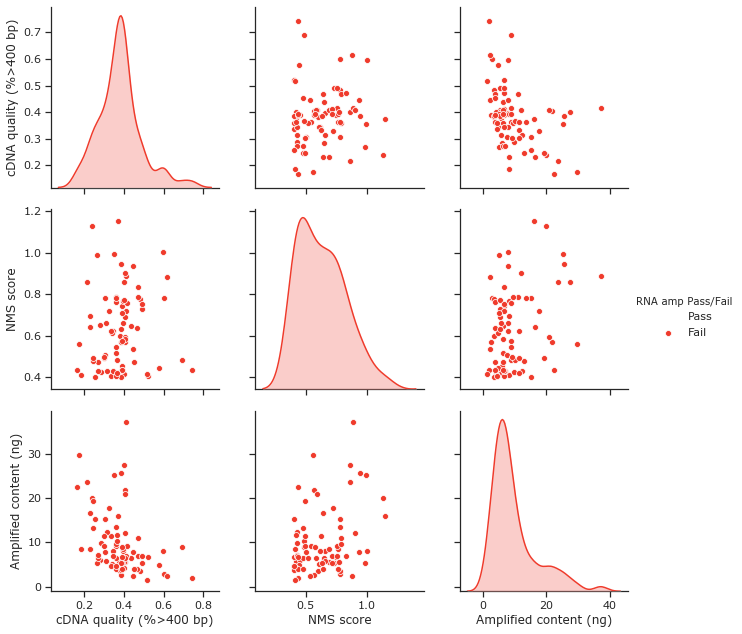

In [17]:
ax = sns.pairplot(data=shinyh, vars=["cDNA quality (%>400 bp)", "NMS score", "Amplified content (ng)"], height=3, 
                  hue = "RNA amp Pass/Fail", hue_order=["Pass", "Fail"], palette=colors)
plt.savefig(plot_path + "human_pairplot.jpeg", bbox_inches="tight")

##### Makes dfs to csvs

In [ ]:
#shiny.to_csv(csv_path + "set_rna_amp.csv")
#true_nms_fail_rna.to_csv(csv_path + "rna_amp.csv")